In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

import torch
from torch.utils.data import DataLoader
from torch import nn, optim

from src.dataset import SpeechDataset
from src.cnn_lstm import CNNLSTM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU utilisé : ",torch.cuda.get_device_name(0))


GPU utilisé :  NVIDIA GeForce RTX 4050 Laptop GPU


In [2]:
dataset = SpeechDataset("../data/processed/mfcc", feature_type="mfcc")
len(dataset)


44652

Padding car sample 1 : [101,40] & sample 2 = [61,40]

In [3]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    xs, ys = zip(*batch)

    # xs = liste de tensors [T_i, 40]
    lengths = torch.tensor([x.shape[0] for x in xs])

    xs = pad_sequence(xs, batch_first=True)  # [batch, max_T, 40]

    ys = torch.tensor(ys, dtype=torch.long)
    return xs, ys, lengths



In [4]:
loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_batch
)


model = CNNLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model


CNNLSTM(
  (conv): Sequential(
    (0): Conv1d(40, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
  )
  (lstm): LSTM(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)

In [5]:
epochs = 20
loss_history = []

for epoch in range(epochs):
    total = 0
    model.train()

    for x, y, lengths in loader:         
        x, y, lengths = x.to(device), y.to(device), lengths.to(device)

        optimizer.zero_grad()
        
        out = model(x, lengths)           
        
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total += loss.item()

    loss_history.append(total)
    print(f"Epoch : {epoch+1} | Loss : {total}")


Epoch : 1 | Loss : 1993.9773870706558
Epoch : 2 | Loss : 1737.8873452544212
Epoch : 3 | Loss : 1560.6191833019257
Epoch : 4 | Loss : 1429.4660477042198
Epoch : 5 | Loss : 1310.6642417907715
Epoch : 6 | Loss : 1205.8469549417496
Epoch : 7 | Loss : 1116.3248337507248
Epoch : 8 | Loss : 1038.9184036552906
Epoch : 9 | Loss : 966.6609581410885
Epoch : 10 | Loss : 907.285331428051
Epoch : 11 | Loss : 870.8527640849352
Epoch : 12 | Loss : 817.0023113340139
Epoch : 13 | Loss : 778.1788117140532
Epoch : 14 | Loss : 755.5653217285872
Epoch : 15 | Loss : 732.0434227734804
Epoch : 16 | Loss : 707.4790749251842
Epoch : 17 | Loss : 682.0263485834002
Epoch : 18 | Loss : 669.931753359735
Epoch : 19 | Loss : 655.7797010689974
Epoch : 20 | Loss : 646.3154073804617


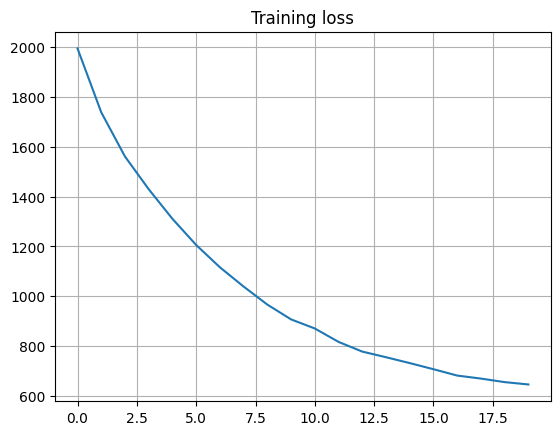

In [6]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.title("Training loss")
plt.grid()
plt.show()


In [7]:
torch.save(model.state_dict(), "models/cnn_lstm.pth")


Notes sur le CNN + LSTM

- Le modèle apprend mais plus lentement que le CNN 2D.
- Les MFCC contiennent moins d’informations que les MelSpectrograms, ce qui limite les performances.
- Le padding ajouté sur les séquences MFCC introduit du bruit dans l’entraînement.
- Le CNN 2D reste plus efficace pour la reconnaissance d’émotion dans notre cas.
